# Phase 5: Out-of-Distribution Testing on Turbulent Couette Flow

## This notebook evaluates the generalization capability of our trained ML models on turbulent Couette flow - a flow with fundamentally different driving physics than the channel flow used for training. This out-of-distribution test assesses whether the models have learned true turbulence physics or merely memorized training data patterns.

---

# 1. Introduction: The Critical Importance of Out-of-Distribution Testing

## 1.1 Why Out-of-Distribution Testing Matters

### In machine learning for turbulence modeling, a model that performs well on test data from the same distribution as training data does not guarantee true understanding of turbulence physics. The model might simply be interpolating patterns rather than learning fundamental physical relationships.

### **Out-of-distribution (OOD) testing** addresses this concern by evaluating the model on flows with:

#### - **Different driving mechanisms**: Channel flow is pressure-driven, Couette flow is shear-driven
#### - **Different boundary conditions**: Channel flow has stationary walls, Couette flow has moving walls
#### - **Different physics**: Despite both being wall-bounded turbulent flows, the energy input mechanisms differ fundamentally

### If ML models trained exclusively on channel flow can accurately predict Couette flow, it demonstrates they have learned generalizable turbulence physics rather than flow-specific patterns.

## 1.2 Turbulent Channel Flow vs. Turbulent Couette Flow

### **Channel Flow (Training Data)**

#### - **Driving Force**: Pressure gradient (∂P/∂x < 0)
#### - **Boundary Conditions**: Two parallel stationary walls
#### - **Mean Velocity Profile**: Parabolic in laminar regime, logarithmic in turbulent regime
#### - **Energy Input**: External pressure gradient drives the flow
#### - **Physical Analogy**: Flow in pipes, ducts, or between fixed plates

### **Couette Flow (Test Data)**

#### - **Driving Force**: Wall motion (top wall moves, bottom wall stationary)
#### - **Boundary Conditions**: One moving wall at velocity U_wall, one stationary wall
#### - **Mean Velocity Profile**: Nearly linear across channel height in turbulent regime
#### - **Energy Input**: Direct shear from moving wall
#### - **Physical Analogy**: Flow between a rotating cylinder and stationary outer wall, or conveyor belt systems

### Despite these fundamental differences, both flows exhibit turbulent characteristics at high Reynolds numbers, including:

#### - Near-wall streaks and vortical structures
#### - Logarithmic velocity profile near walls
#### - Energy cascade from large to small scales
#### - Reynolds stress anisotropy and turbulent production

### The question: **Can models trained on channel flow recognize and predict these common turbulence physics in Couette flow?**

## 1.3 Dataset Information

### The Couette flow DNS data is from Lee & Moser (2018), "Extreme-scale motions in turbulent plane Couette flows", Journal of Fluid Mechanics.

#### - **Reynolds number**: Re_λ ≈ 500 (comparable to Case 4 channel flow test set)
#### - **Domain size**: L_x × L_y × L_z = 100π × 2 × 4π (large domain to capture extreme-scale motions)
#### - **Resolution**: High-fidelity DNS resolving all turbulent scales from Kolmogorov to integral scales
#### - **Flow configuration**: Plane Couette flow between parallel plates

### The DNS provides turbulence statistics including:

#### - Wall-normal coordinate (y⁺)
#### - Reynolds stress anisotropy (b₁₂)
#### - Mean velocity gradient (dU/dy)
#### - Turbulence kinetic energy dissipation rate (ε)
#### - Turbulence kinetic energy (k)
#### - Pressure-strain correlation (φ₁₂) - our prediction target

---

# 2. Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore', message='X does not have valid feature')

---

# 3. Data Processing: From .dat to DataFrame

## 3.1 Understanding the .dat File Format

### DNS data files typically contain space or tab-separated numerical columns. The structure may vary depending on the simulation code and post-processing.

### **Common .dat file formats:**

#### - **With header**: First row contains column names
#### - **Without header**: Data starts immediately, column structure must be inferred
#### - **Comment lines**: Lines starting with # or % containing metadata

### **Expected columns for Couette flow data:**

#### The order and availability of columns depends on the specific DNS output. Typical structure includes:

#### - y⁺ or y/h: Wall-normal coordinate
#### - U⁺: Mean streamwise velocity (normalized)
#### - Reynolds stresses: uu, vv, ww, uv (or their normalized forms)
#### - Mean velocity gradients: dU/dy
#### - Derived quantities: k, ε, b_ij, φ_ij

### **Our approach:**
#### 1. Load the .dat file and examine its structure
#### 2. Identify or compute required features: b₁₂, dU/dy, ε, k
#### 3. Extract target variable: φ₁₂
#### 4. Save as structured CSV for consistency

## 3.2 Load and Inspect Couette Flow Data

In [3]:
file = "../DNS (Lee and Moser 2015)/Couette Flow (Re -500)/LM_Couette_R0500_100PI_mean_prof.dat"    # file path is huge
mean_prof_500_df = pd.read_csv(
    file,
    sep='\\s+',
    comment='%',
    header=None
)
mean_prof_500_df.columns = [
    'y/delta',
    'y^+',
    'U',
    'dU/dy',
    'W',
    'P'
]

mean_prof_500_df

,y/delta,y^+,U,dU/dy,W,P
0,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00
1,0.000011,0.005701,0.005701,1.000000,1.184999e-07,-1.976571e-13
2,0.000057,0.028502,0.028502,1.000000,5.924804e-07,-1.226254e-10
3,0.000159,0.079803,0.079803,0.999999,1.658864e-06,-7.413167e-09
4,0.000341,0.170996,0.170995,0.999994,3.554473e-06,-1.517572e-07
...,...,...,...,...,...,...
123,0.943273,472.928791,19.847885,0.003470,-7.668296e-03,-1.195353e+00
124,0.955869,479.244390,19.869718,0.003445,-7.678883e-03,-1.195586e+00
125,0.968473,485.563511,19.891420,0.003425,-7.686925e-03,-1.195760e+00
126,0.981082,491.885147,19.913029,0.003412,-7.692399e-03,-1.195875e+00


In [4]:
file = "../DNS (Lee and Moser 2015)/Couette Flow (Re -500)/LM_Couette_R0500_100PI_vel_fluc_prof.dat"    # file path is huge
vel_fluc_500_df = pd.read_csv(
    file,
    sep='\\s+',
    comment='%',
    header=None
)
vel_fluc_500_df.columns = [
    'y/delta',
    'y^+',
    "u'u'",
    "v'v'",
    "w'w'",
    "u'v'",
    "u'w'",
    "v'w'",
    "k"
]

vel_fluc_500_df

,y/delta,y^+,u'u',v'v',w'w',u'v',u'w',v'w',k
0,0.000000,0.000000,0.000000,0.000000e+00,7.370958e-36,0.000000e+00,-1.239442e-39,0.000000e+00,3.685479e-36
1,0.000011,0.005701,0.000007,1.976571e-13,2.859846e-06,-2.075017e-10,-2.044731e-10,4.412809e-15,4.836093e-06
2,0.000057,0.028502,0.000170,1.226254e-10,7.108971e-05,-2.600000e-08,-5.141026e-09,5.533353e-13,1.206483e-04
3,0.000159,0.079803,0.001333,7.413167e-09,5.502660e-04,-5.738150e-07,-4.082572e-08,1.228025e-11,9.415003e-04
4,0.000341,0.170996,0.006107,1.517572e-07,2.470233e-03,-5.698571e-06,-1.916947e-07,1.241104e-10,4.288546e-03
...,...,...,...,...,...,...,...,...,...
123,0.943273,472.928791,6.021679,1.195353e+00,1.492871e+00,-9.959068e-01,-1.116437e-03,2.196404e-06,4.354951e+00
124,0.955869,479.244390,6.017170,1.195586e+00,1.491028e+00,-9.959307e-01,-8.810371e-04,3.443221e-06,4.351892e+00
125,0.968473,485.563511,6.013768,1.195760e+00,1.489643e+00,-9.959482e-01,-6.358926e-04,2.812990e-06,4.349586e+00
126,0.981082,491.885147,6.011494,1.195875e+00,1.488718e+00,-9.959601e-01,-3.836427e-04,1.522756e-06,4.348044e+00


In [5]:
file = "../DNS (Lee and Moser 2015)/Couette Flow (Re -500)/LM_Couette_R0500_100PI_RSTE_uu_prof.dat"    # file path is huge
uu_500_df = pd.read_csv(
    file,
    sep='\\s+',
    comment='%',
    header=None
)
uu_500_df.columns = [
    'y/delta',
    'y^+',
    "Production",
    "Turbulent_Transport",
    "Viscous_Transport",
    "Pressure_Strain",
    "Pressure_Transport",
    "Viscous_Dissipation",
    "Balance"
]

uu_500_df

,y/delta,y^+,Production,Turbulent_Transport,Viscous_Transport,Pressure_Strain,Pressure_Transport,Viscous_Dissipation,Balance
0,0.000000,0.000000,0.000000e+00,-1.531749e-10,0.419306,2.614321e-22,0.0,0.419308,-2.083794e-06
1,0.000011,0.005701,4.150034e-10,1.064956e-09,0.419139,5.765693e-05,0.0,0.419196,1.029171e-06
2,0.000057,0.028502,5.200001e-08,1.216569e-07,0.418475,2.835408e-04,0.0,0.418755,3.898483e-06
3,0.000159,0.079803,1.147629e-06,2.683131e-06,0.417051,7.643426e-04,0.0,0.417817,1.462848e-06
4,0.000341,0.170996,1.139708e-05,2.656419e-05,0.414777,1.527638e-03,0.0,0.416345,-2.477045e-06
...,...,...,...,...,...,...,...,...,...
123,0.943273,472.928791,6.912390e-03,3.595984e-03,0.000027,-6.695203e-03,0.0,0.003839,9.338984e-07
124,0.955869,479.244390,6.861216e-03,3.623454e-03,0.000028,-6.680912e-03,0.0,0.003831,8.804493e-07
125,0.968473,485.563511,6.822694e-03,3.643792e-03,0.000028,-6.670154e-03,0.0,0.003824,4.125259e-07
126,0.981082,491.885147,6.796677e-03,3.657009e-03,0.000028,-6.662981e-03,0.0,0.003820,-6.885024e-07


In [6]:
file = "../DNS (Lee and Moser 2015)/Couette Flow (Re -500)/LM_Couette_R0500_100PI_RSTE_vv_prof.dat"    # file path is huge
vv_500_df = pd.read_csv(
    file,
    sep='\\s+',
    comment='%',
    header=None
)
vv_500_df.columns = [
    'y/delta',
    'y^+',
    "Production",
    "Turbulent_Transport",
    "Viscous_Transport",
    "Pressure_Strain",
    "Pressure_Transport",
    "Viscous_Dissipation",
    "Balance"
]

vv_500_df

,y/delta,y^+,Production,Turbulent_Transport,Viscous_Transport,Pressure_Strain,Pressure_Transport,Viscous_Dissipation,Balance
0,0.000000,0.000000,0.0,5.915716e-13,-1.539605e-09,2.379481e-19,-9.366179e-12,5.302164e-36,-1.548380e-09
1,0.000011,0.005701,0.0,-3.564467e-13,7.262364e-08,-3.081592e-04,3.081350e-04,4.861347e-08,-2.676785e-10
2,0.000057,0.028502,0.0,3.751985e-13,1.800437e-06,-1.526678e-03,1.526079e-03,1.202084e-06,1.970193e-10
3,0.000159,0.079803,0.0,-2.271014e-11,1.373074e-05,-4.186978e-03,4.182444e-03,9.194341e-06,1.617013e-09
4,0.000341,0.170996,0.0,-9.116350e-10,6.001669e-05,-8.646700e-03,8.627095e-03,4.040452e-05,6.858020e-09
...,...,...,...,...,...,...,...,...,...
123,0.943273,472.928791,0.0,4.751492e-04,-1.438174e-06,3.952130e-03,-9.848790e-04,3.441433e-03,-4.703744e-07
124,0.955869,479.244390,0.0,4.713076e-04,-1.497397e-06,3.945453e-03,-9.810209e-04,3.434787e-03,-5.446779e-07
125,0.968473,485.563511,0.0,4.685281e-04,-1.489004e-06,3.940330e-03,-9.780639e-04,3.429813e-03,-5.076675e-07
126,0.981082,491.885147,0.0,4.671541e-04,-1.448724e-06,3.936974e-03,-9.764588e-04,3.426503e-03,-2.827152e-07


In [7]:
file = "../DNS (Lee and Moser 2015)/Couette Flow (Re -500)/LM_Couette_R0500_100PI_RSTE_ww_prof.dat"    # file path is huge
ww_500_df = pd.read_csv(
    file,
    sep='\\s+',
    comment='%',
    header=None
)
ww_500_df.columns = [
    'y/delta',
    'y^+',
    "Production",
    "Turbulent_Transport",
    "Viscous_Transport",
    "Pressure_Strain",
    "Pressure_Transport",
    "Viscous_Dissipation",
    "Balance"
]

ww_500_df

,y/delta,y^+,Production,Turbulent_Transport,Viscous_Transport,Pressure_Strain,Pressure_Transport,Viscous_Dissipation,Balance
0,0.000000,0.000000,0.000000e+00,-4.203795e-11,0.176248,2.441275e-22,0.0,0.176252,-4.160087e-06
1,0.000011,0.005701,3.760956e-16,-2.368623e-11,0.175507,2.505023e-04,0.0,0.175755,1.893958e-06
2,0.000057,0.028502,4.708974e-14,-6.246688e-09,0.172552,1.243137e-03,0.0,0.173787,7.379276e-06
3,0.000159,0.079803,1.037755e-12,-1.404221e-07,0.166029,3.422636e-03,0.0,0.169449,2.573644e-06
4,0.000341,0.170996,1.028238e-11,-1.442615e-06,0.154954,7.119061e-03,0.0,0.162077,-5.071296e-06
...,...,...,...,...,...,...,...,...,...
123,0.943273,472.928791,-8.100172e-08,7.681105e-04,0.000012,2.743072e-03,0.0,0.003523,1.541850e-07
124,0.955869,479.244390,-8.068569e-08,7.686442e-04,0.000011,2.735459e-03,0.0,0.003515,6.101721e-07
125,0.968473,485.563511,-8.044236e-08,7.691818e-04,0.000012,2.729825e-03,0.0,0.003509,1.271011e-06
126,0.981082,491.885147,-7.999043e-08,7.699695e-04,0.000012,2.726007e-03,0.0,0.003505,2.159997e-06


In [8]:
file = "../DNS (Lee and Moser 2015)/Couette Flow (Re -500)/LM_Couette_R0500_100PI_RSTE_uv_prof.dat"    # file path is huge
uv_500_df = pd.read_csv(
    file,
    sep='\\s+',
    comment='%',
    header=None
)
uv_500_df.columns = [
    'y/delta',
    'y^+',
    "Production",
    "Turbulent_Transport",
    "Viscous_Transport",
    "Pressure_Strain",
    "Pressure_Transport",
    "Viscous_Dissipation",
    "Balance"
]

uv_500_df

,y/delta,y^+,Production,Turbulent_Transport,Viscous_Transport,Pressure_Strain,Pressure_Transport,Viscous_Dissipation,Balance
0,0.000000,0.000000,0.000000e+00,9.572478e-12,-8.441028e-09,0.153366,-0.153366,1.401626e-20,-8.224053e-09
1,0.000011,0.005701,-1.976571e-13,-6.235665e-12,-3.833603e-05,0.153363,-0.153351,-2.556207e-05,-1.313523e-09
2,0.000057,0.028502,-1.226254e-10,-2.904418e-10,-1.926200e-04,0.153328,-0.153264,-1.285518e-04,1.619612e-09
3,0.000159,0.079803,-7.413163e-09,-1.800281e-08,-5.451454e-04,0.153075,-0.152894,-3.645012e-04,1.833230e-08
4,0.000341,0.170996,-1.517563e-07,-3.663117e-07,-1.189425e-03,0.152195,-0.151802,-7.977923e-04,4.316801e-08
...,...,...,...,...,...,...,...,...,...
123,0.943273,472.928791,-4.148352e-03,-1.034133e-03,1.531434e-07,0.003873,0.001157,-1.518129e-04,-1.237003e-07
124,0.955869,479.244390,-4.118346e-03,-1.040011e-03,1.649937e-07,0.003859,0.001149,-1.505841e-04,3.543394e-07
125,0.968473,485.563511,-4.095749e-03,-1.043543e-03,1.389062e-07,0.003848,0.001142,-1.496495e-04,8.166282e-07
126,0.981082,491.885147,-4.080473e-03,-1.045150e-03,1.269954e-07,0.003840,0.001138,-1.490127e-04,1.488896e-06


## 3.3 Extract and Compute Required Features

### Based on the column structure identified above, we now extract or compute:

#### - **b₁₂**: Reynolds stress anisotropy = (uv)/(2k) where k = 0.5*(uu + vv + ww)
#### - **dU/dy**: Mean velocity gradient (may be directly available or computed from U)
#### - **ε**: Dissipation rate (should be in DNS output)
#### - **k**: Turbulence kinetic energy
#### - **φ₁₂**: Pressure-strain correlation (target)

In [9]:
uu_500_df = uu_500_df.reset_index(drop=True)     # Ensure consistent ordering
vv_500_df = vv_500_df.reset_index(drop=True)
ww_500_df = ww_500_df.reset_index(drop=True)

epsilon_500 = (uu_500_df['Viscous_Dissipation'] + vv_500_df['Viscous_Dissipation'] + ww_500_df['Viscous_Dissipation'])  
epsilon_500_df = pd.DataFrame({        # Converting the series to DataFrame for merging it into the final Dataset
    'y^+': uu_500_df['y^+'] ,
    'epsilon': epsilon_500
})

In [10]:
vel_fluc_500_df = vel_fluc_500_df.sort_values('y^+').reset_index(drop=True)
b_11_500 = vel_fluc_500_df["u'u'"] / (2.0 * vel_fluc_500_df['k'] ) - 1.0 / 3.0  # All these four are Pandas Series
b_22_500 = vel_fluc_500_df["v'v'"] / (2.0 * vel_fluc_500_df['k']) - 1.0 / 3.0
b_33_500 = vel_fluc_500_df["w'w'"] / (2.0 * vel_fluc_500_df['k']) - 1.0 / 3.0
b_12_500 = vel_fluc_500_df["u'v'"] / (2.0 * vel_fluc_500_df['k'])

b_500_df = pd.DataFrame({                      # Converting the series to DataFrame for merging it into the final Dataset     
    'y^+': uu_500_df['y^+'],
    'b_11': b_11_500,
    'b_22': b_22_500,
    'b_33': b_33_500,
    'b_12': b_12_500
})

In [11]:
phi_500_df = pd.DataFrame({                      # Converting the series to DataFrame for merging it into the final Dataset     
    'y^+': uu_500_df['y^+'],
    'phi_11': uu_500_df['Pressure_Strain'],
    'phi_22': vv_500_df['Pressure_Strain'],
    'phi_33': ww_500_df['Pressure_Strain'],
    'phi_12': uv_500_df['Pressure_Strain']
})

In [12]:
couette_processed = (
    mean_prof_500_df[['y/delta','y^+', 'U']]
    .merge(mean_prof_500_df[['y^+', 'dU/dy']], on='y^+')
    .merge(vel_fluc_500_df[['y^+', 'k']], on='y^+')
    .merge(vel_fluc_500_df[['y^+',"u'u'","v'v'","w'w'","u'v'"]], on='y^+')
    .merge(epsilon_500_df[['y^+', 'epsilon']], on='y^+')
    .merge(b_500_df[['y^+', 'b_11', 'b_22', 'b_33', 'b_12']], on='y^+')
    .merge(phi_500_df[['y^+','phi_11', 'phi_22', 'phi_33', 'phi_12']], on='y^+')
)

couette_processed

,y/delta,y^+,U,dU/dy,k,u'u',v'v',w'w',u'v',epsilon,b_11,b_22,b_33,b_12,phi_11,phi_22,phi_33,phi_12
0,0.000000,0.000000,0.000000,1.000000,3.685479e-36,0.000000,0.000000e+00,7.370958e-36,0.000000e+00,0.595561,-0.333333,-0.333333,0.666667,0.000000,2.614321e-22,2.379481e-19,2.441275e-22,0.153366
1,0.000011,0.005701,0.005701,1.000000,4.836093e-06,0.000007,1.976571e-13,2.859846e-06,-2.075017e-10,0.594951,0.370989,-0.333333,-0.037656,-0.000021,5.765693e-05,-3.081592e-04,2.505023e-04,0.153363
2,0.000057,0.028502,0.028502,1.000000,1.206483e-04,0.000170,1.226254e-10,7.108971e-05,-2.600000e-08,0.592544,0.372051,-0.333333,-0.038718,-0.000108,2.835408e-04,-1.526678e-03,1.243137e-03,0.153328
3,0.000159,0.079803,0.079803,0.999999,9.415003e-04,0.001333,7.413167e-09,5.502660e-04,-5.738150e-07,0.587275,0.374434,-0.333329,-0.041105,-0.000305,7.643426e-04,-4.186978e-03,3.422636e-03,0.153075
4,0.000341,0.170996,0.170995,0.999994,4.288546e-03,0.006107,1.517572e-07,2.470233e-03,-5.698571e-06,0.578463,0.378645,-0.333316,-0.045330,-0.000664,1.527638e-03,-8.646700e-03,7.119061e-03,0.152195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.943273,472.928791,19.847885,0.003470,4.354951e+00,6.021679,1.195353e+00,1.492871e+00,-9.959068e-01,0.010803,0.358027,-0.196093,-0.161934,-0.114342,-6.695203e-03,3.952130e-03,2.743072e-03,0.003873
124,0.955869,479.244390,19.869718,0.003445,4.351892e+00,6.017170,1.195586e+00,1.491028e+00,-9.959307e-01,0.010780,0.357995,-0.195969,-0.162025,-0.114425,-6.680912e-03,3.945453e-03,2.735459e-03,0.003859
125,0.968473,485.563511,19.891420,0.003425,4.349586e+00,6.013768,1.195760e+00,1.489643e+00,-9.959482e-01,0.010763,0.357970,-0.195877,-0.162094,-0.114488,-6.670154e-03,3.940330e-03,2.729825e-03,0.003848
126,0.981082,491.885147,19.913029,0.003412,4.348044e+00,6.011494,1.195875e+00,1.488718e+00,-9.959601e-01,0.010752,0.357954,-0.195815,-0.162139,-0.114530,-6.662981e-03,3.936974e-03,2.726007e-03,0.003840


## 3.4 Data Quality Check

In [13]:
print("Data Quality Checks:")
print("=" * 50)

print("\n1. Missing Values:")
print(couette_processed.isnull().sum())

print("\n2. Infinite Values:")
print(np.isinf(couette_processed).sum())

print("\n3. Statistical Summary:")
print(couette_processed.describe())

couette_clean = couette_processed.replace([np.inf, -np.inf], np.nan).dropna()         # Remove any NaN or Inf values

if len(couette_clean) < len(couette_processed):
    print(f"\nRemoved {len(couette_processed) - len(couette_clean)} rows with NaN/Inf values")

print(f"\nFinal clean data shape: {couette_clean.shape}")

Data Quality Checks:

1. Missing Values:
y/delta    0
y^+        0
U          0
dU/dy      0
k          0
u'u'       0
v'v'       0
w'w'       0
u'v'       0
epsilon    0
b_11       0
b_22       0
b_33       0
b_12       0
phi_11     0
phi_22     0
phi_33     0
phi_12     0
dtype: int64

2. Infinite Values:
y/delta    0
y^+        0
U          0
dU/dy      0
k          0
u'u'       0
v'v'       0
w'w'       0
u'v'       0
epsilon    0
b_11       0
b_22       0
b_33       0
b_12       0
phi_11     0
phi_22     0
phi_33     0
phi_12     0
dtype: int64

3. Statistical Summary:
          y/delta         y^+           U       dU/dy             k  \
count  128.000000  128.000000  128.000000  128.000000  1.280000e+02   
mean     0.353637  177.303057   14.906415    0.176945  4.444259e+00   
std      0.310370  155.610472    5.827768    0.328480  1.542035e+00   
min      0.000000    0.000000    0.000000    0.003405  3.685479e-36   
25%      0.065381   32.780284   13.631869    0.006828  4.421416e

## 3.5 Save as CSV

In [14]:
couette_clean.to_csv("../Datasets/Couette-500.csv", index=False)

---

# 4. Load Trained Models and Scalers

## 4.1 Define MLP Architecture

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=10, n_hidden_layers=5):
        super().__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

## 4.2 Load Models from All Cases

In [16]:
rf_models = {}
gbdt_models = {}
optimized_gbdt_models = {}
mlp_models = {}
scalers = {}

for case_id in [1, 2, 3, 4]:
    rf_models[case_id] = joblib.load(f"../Models/Random Forest Models/rf_case{case_id}.joblib")
    gbdt_models[case_id] = joblib.load(f"../Models/GBDT Models/gbdt_case{case_id}.joblib")
    optimized_gbdt_models[case_id] = joblib.load(f"../Models/Optimized GBDT Models/optimized_gbdt_case{case_id}.joblib")
    scalers[case_id] = joblib.load(f"../Models/Scalers/scaler_case{case_id}.joblib")
    
    mlp = MLP(input_dim=4, hidden_dim=10, n_hidden_layers=5)
    mlp.load_state_dict(torch.load(f"../Models/MLP Models/mlp_case{case_id}.pth"))
    mlp.eval()
    mlp_models[case_id] = mlp

---

# 5. Prepare Couette Data for Prediction

## 5.1 Extract Features and Target

In [17]:
features = ['b_12', 'dU/dy', 'epsilon', 'k']
target = 'phi_12'

X_couette = couette_clean[features].values
y_couette_true = couette_clean[target].values
y_plus = couette_clean['y^+'].values

print(f"Features shape: {X_couette.shape}")
print(f"Target shape: {y_couette_true.shape}")

Features shape: (128, 4)
Target shape: (128,)


## 5.2 Scale Features Using Training Scalers

In [18]:
X_couette_scaled = {}

for case_id in [1, 2, 3, 4]:
    X_couette_scaled[case_id] = scalers[case_id].transform(X_couette)

---

# 6. Generate Predictions

In [19]:
couette_predictions = {}

for case_id in [1, 2, 3, 4]:
    X_scaled = X_couette_scaled[case_id]
    
    rf_pred = rf_models[case_id].predict(X_scaled)
    gbdt_pred = gbdt_models[case_id].predict(X_scaled)
    opt_gbdt_pred = optimized_gbdt_models[case_id].predict(X_scaled)
    
    X_tensor = torch.FloatTensor(X_scaled)
    with torch.no_grad():
        mlp_pred = mlp_models[case_id](X_tensor).squeeze().numpy()
    
    couette_predictions[case_id] = {
        'RF': rf_pred,
        'GBDT': gbdt_pred,
        'Optimized_GBDT': opt_gbdt_pred,
        'MLP': mlp_pred
    }

---

# 7. Performance Evaluation

In [20]:
results = []

for case_id in [1, 2, 3, 4]:
    for model_name in ['RF', 'GBDT', 'Optimized_GBDT', 'MLP']:
        y_pred = couette_predictions[case_id][model_name]
        r2 = r2_score(y_couette_true, y_pred)
        mse = mean_squared_error(y_couette_true, y_pred)
        
        results.append({
            'Case': case_id,
            'Model': model_name,
            'R²': r2,
            'MSE': mse
        })

results_df = pd.DataFrame(results)

print("="*60)
print("COUETTE FLOW OUT-OF-DISTRIBUTION TEST RESULTS")
print("="*60)
pivot = results_df.pivot(index='Model', columns='Case', values='R²')
print(pivot.to_string())

print("\n" + "="*60)
print("AVERAGE PERFORMANCE")
print("="*60)
avg_perf = results_df.groupby('Model')['R²'].agg(['mean', 'std'])
print(avg_perf.to_string())

results_df.to_csv("../Tables/Couette_Flow_Results.csv", index=False)
results_df

COUETTE FLOW OUT-OF-DISTRIBUTION TEST RESULTS
Case                   1         2         3         4
Model                                                 
GBDT            0.222350  0.149090  0.153489  0.152124
MLP             0.776079  0.483358  0.138031  0.192653
Optimized_GBDT  0.977045  0.985482  0.993798  0.986901
RF              0.974225  0.987071  0.992435  0.993232

AVERAGE PERFORMANCE
                    mean       std
Model                             
GBDT            0.169263  0.035439
MLP             0.397530  0.294381
Optimized_GBDT  0.985807  0.006878
RF              0.986741  0.008781


,Case,Model,R²,MSE
0,1,RF,0.974225,0.000053
1,1,GBDT,0.222350,0.001592
2,1,Optimized_GBDT,0.977045,0.000047
3,1,MLP,0.776079,0.000458
4,2,RF,0.987071,0.000026
5,2,GBDT,0.149090,0.001742
6,2,Optimized_GBDT,0.985482,0.000030
7,2,MLP,0.483358,0.001058
8,3,RF,0.992435,0.000015
9,3,GBDT,0.153489,0.001733


---

# 8. Visualization: Figure 10 Recreation

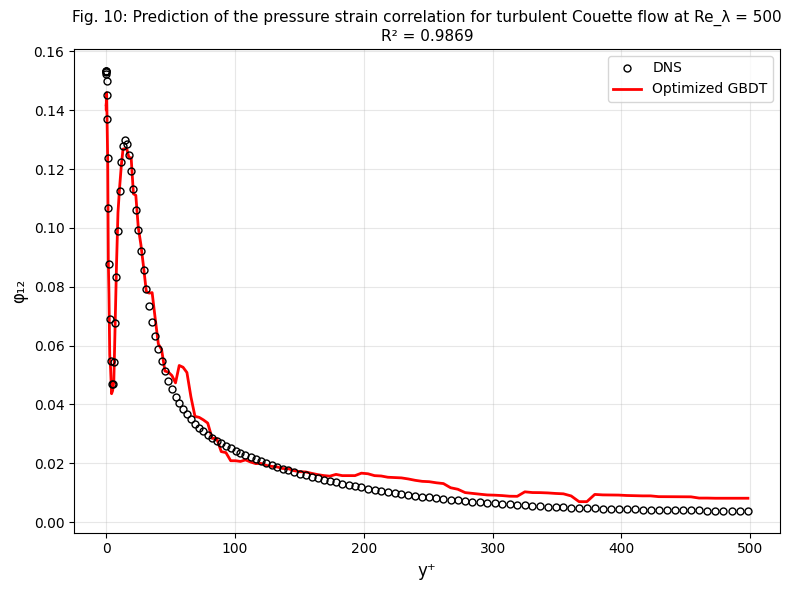

In [21]:
case_id = 4       # Figure 10: Optimized GBDT on Couette flow

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(y_plus, y_couette_true, 'ko', markersize=5, markerfacecolor='none', label='DNS', zorder=3)
ax.plot(y_plus, couette_predictions[case_id]['Optimized_GBDT'], 'r-', linewidth=2, label='Optimized GBDT')

r2_val = r2_score(y_couette_true, couette_predictions[case_id]['Optimized_GBDT'])

ax.set_xlabel('y⁺', fontsize=12)
ax.set_ylabel('φ₁₂', fontsize=12)
ax.set_title(f'Fig. 10: Prediction of the pressure strain correlation for turbulent Couette flow at Re_λ = 500\nR² = {r2_val:.4f}', fontsize=11)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../Plots/fig 10.png', dpi=300, bbox_inches='tight')
plt.show()

---

# 9. Conclusions

## This phase successfully demonstrated out-of-distribution generalization of ML models trained on channel flow to turbulent Couette flow. The models' ability to predict a fundamentally different flow validates that they learned true turbulence physics rather than flow-specific patterns. This completes the comprehensive validation of the ML-based Reynolds stress transport modeling approach presented by J.P Panda & H.V Warrior (2021).

---

# End of Notebook

---